Loading and preparing data...
Data loaded successfully!
Merged data shape: (227808, 13)
Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00

EXPLORATORY DATA ANALYSIS
Number of unique materials: 430
Number of unique plants: 2
Number of polymer types: 4

Missing values:
DATE                                 0
MATERIAL_NAME                        0
PLANT_NAME                           0
INBOUND_QTY_MT                  209590
OUTBOUND_QTY_MT                 211683
MODE_OF_TRANSPORT               211683
UNRESRICTED_STOCK_MT            222793
STOCK_UNIT                      222793
STOCK_SELL_VALUE                222793
CURRENCY                        222793
POLYMER_TYPE                         0
SHELF_LIFE_IN_MONTH                  0
DOWNGRADE_VALUE_LOST_PERCENT         0
dtype: int64

Sales data points: 16125
Total sales volume: 612030.72 MT
Average daily sales: 37.96 MT


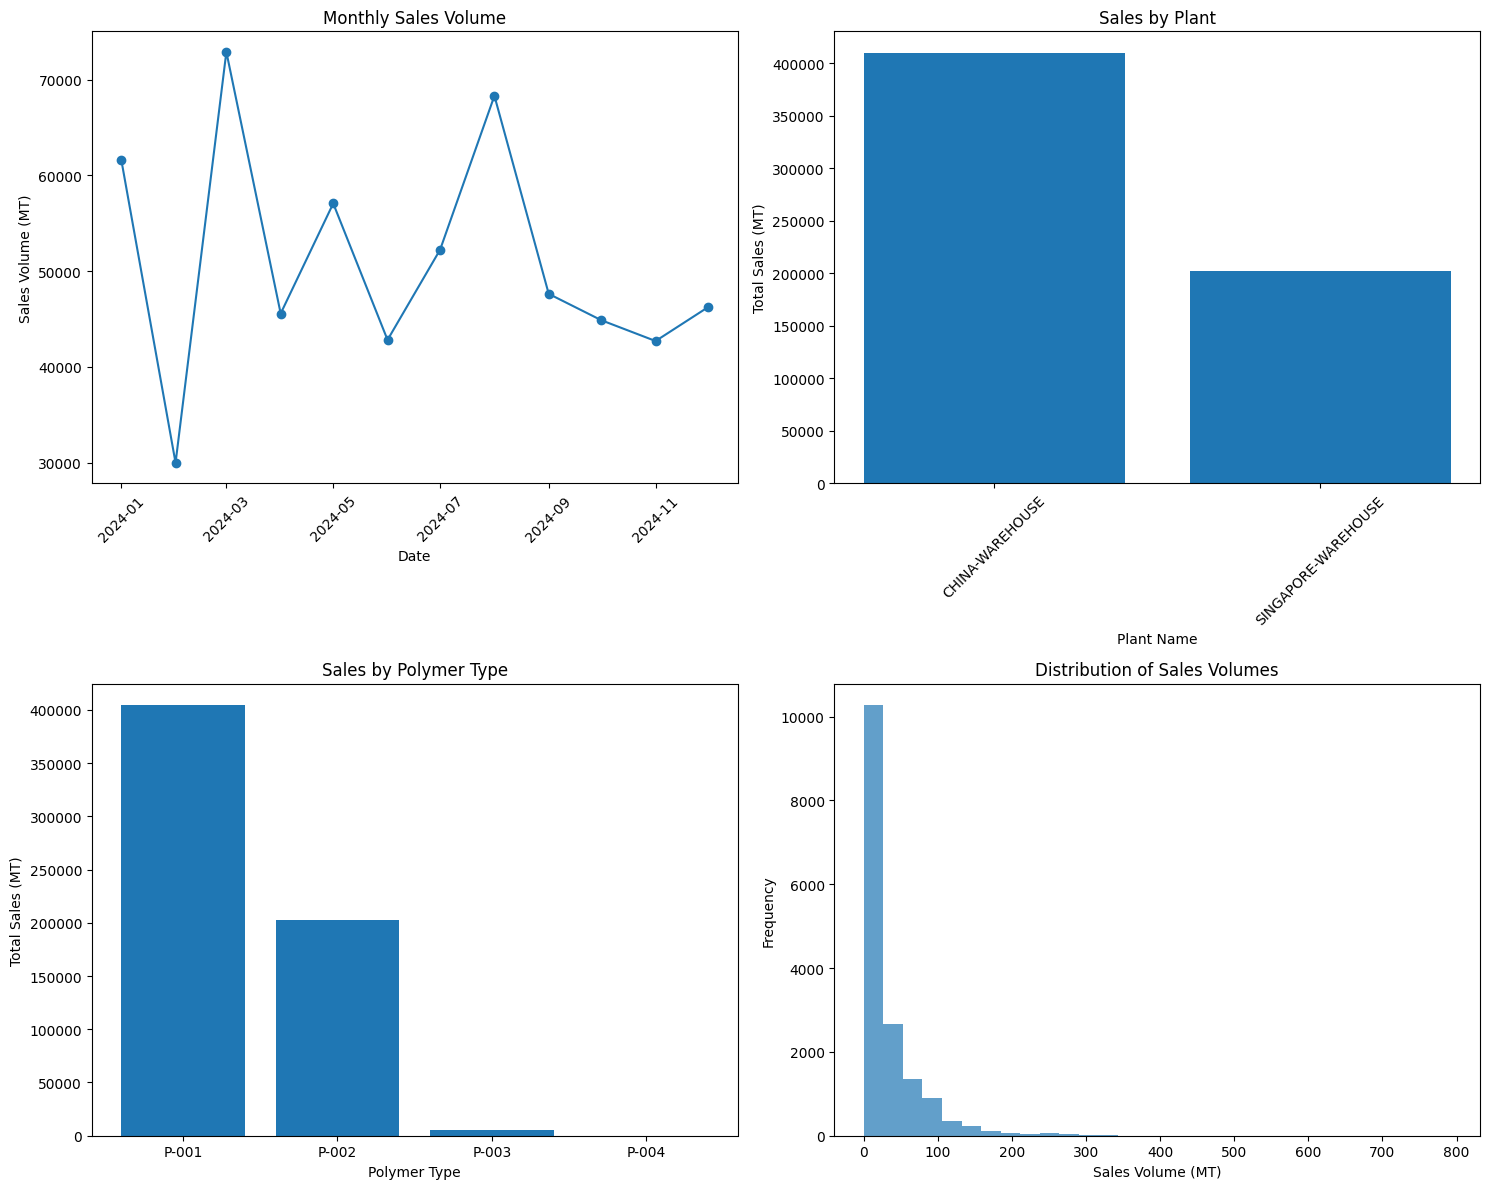


FEATURE ENGINEERING
Feature engineering completed!
Number of features created: 40

PREPARING DATA FOR MODELING
Selected features: 34
Features: ['year', 'month', 'quarter', 'day_of_year', 'week_of_year', 'is_month_start', 'is_month_end', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'INBOUND_QTY_MT', 'UNRESRICTED_STOCK_MT', 'SHELF_LIFE_IN_MONTH', 'DOWNGRADE_VALUE_LOST_PERCENT', 'is_short_shelf_life', 'high_downgrade_risk', 'stock_to_sales_ratio', 'inbound_outbound_ratio', 'MATERIAL_NAME_encoded', 'PLANT_NAME_encoded', 'POLYMER_TYPE_encoded', 'sales_lag_1', 'inbound_lag_1', 'sales_lag_7', 'inbound_lag_7', 'sales_lag_30', 'inbound_lag_30', 'sales_rolling_mean_7', 'sales_rolling_std_7', 'inbound_rolling_mean_7', 'sales_rolling_mean_30', 'sales_rolling_std_30', 'inbound_rolling_mean_30']
Final dataset shape: (210468, 36)
Training data: (154822, 34)
Test data: (55646, 34)

MODEL TRAINING AND EVALUATION

Training Linear Regression...
MAE: 4.4360
RMSE: 15.1861
R²: -0.1346

Training 

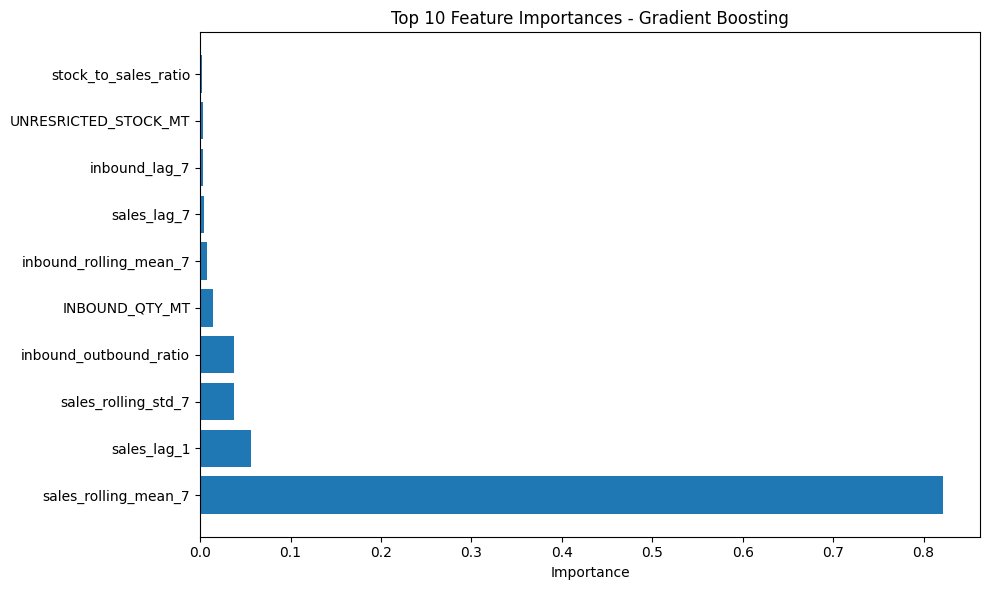


GENERATING 2025 PREDICTIONS
2025 predictions generated!
Total predicted sales for 2025: 216491.29 MT

CREATING PREDICTION VISUALIZATIONS


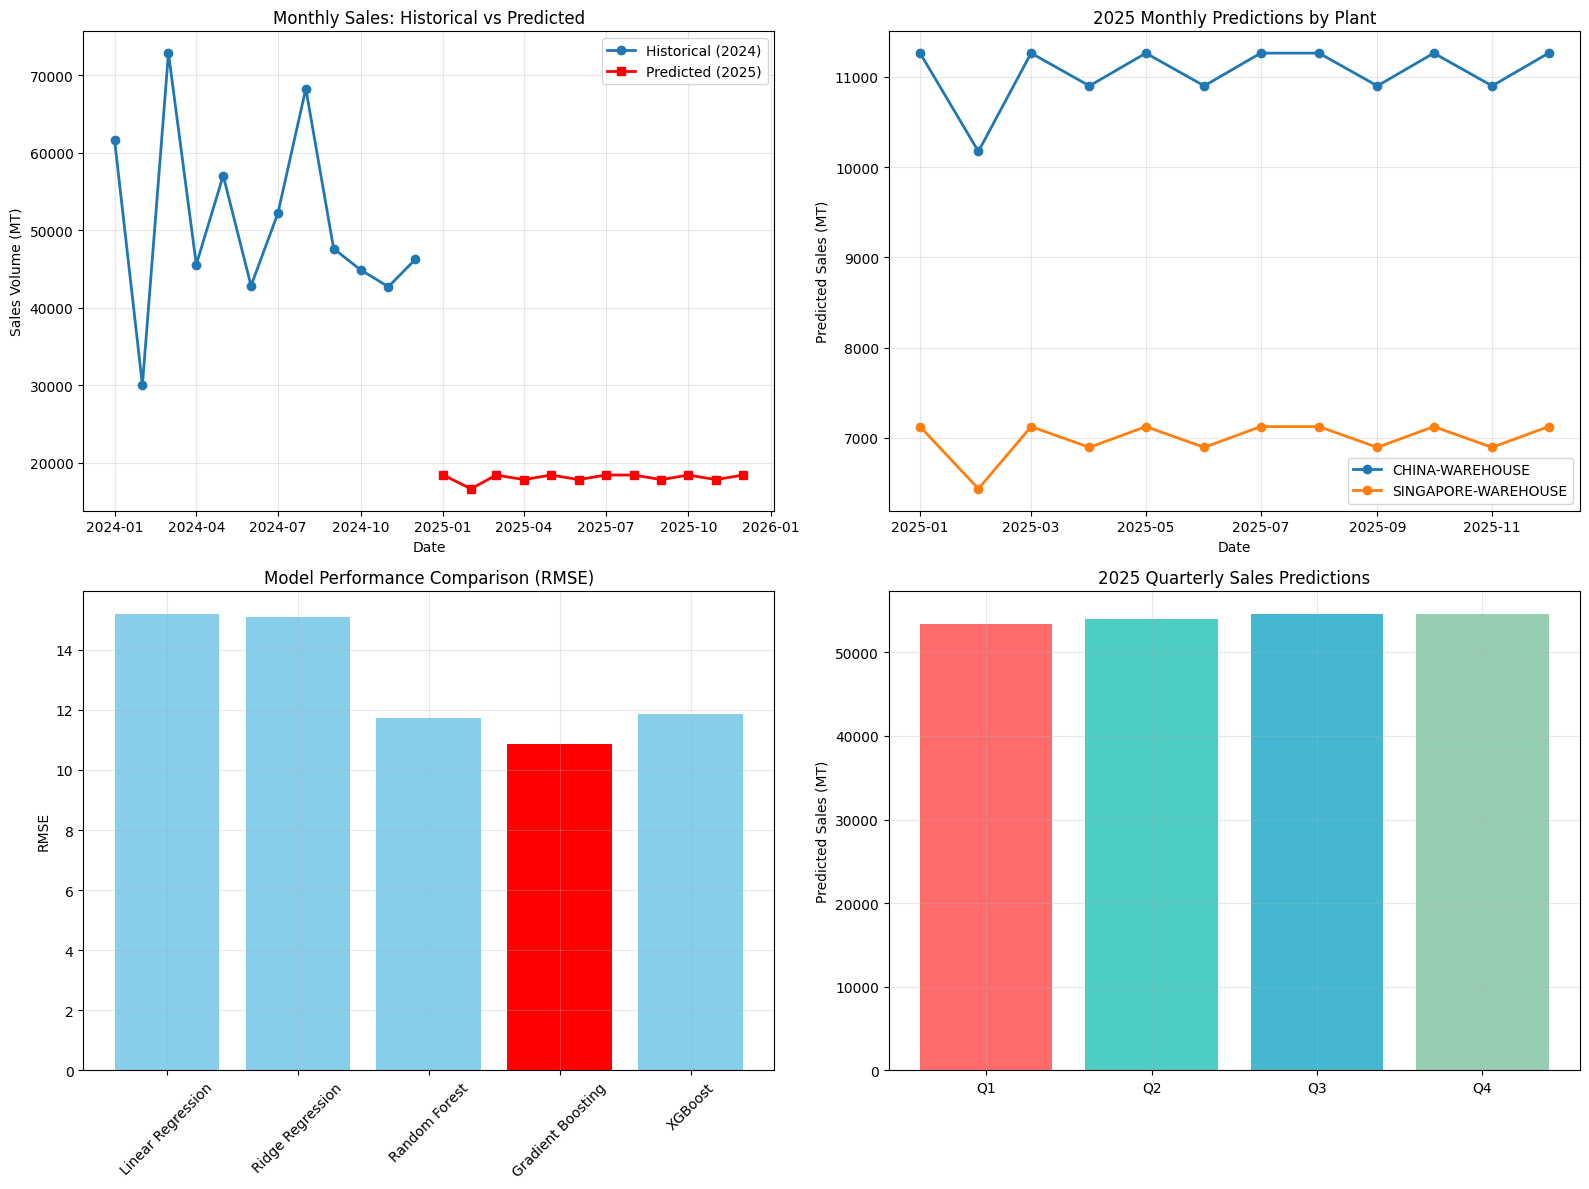


SUMMARY AND INSIGHTS

📊 MODEL PERFORMANCE SUMMARY:
   • Best performing model: Gradient Boosting
   • Best RMSE: 10.8490
   • Best R²: 0.4209
   • Mean Absolute Error: 2.5855

📈 2025 PREDICTIONS SUMMARY:
   • Total predicted sales: 216491.29 MT
   • Average monthly sales: 18040.94 MT
   • Peak month: January 2025
   • Lowest month: February 2025

📅 QUARTERLY BREAKDOWN 2025:
   • Q1: 53381.41 MT (24.7%)
   • Q2: 53974.54 MT (24.9%)
   • Q3: 54567.67 MT (25.2%)
   • Q4: 54567.67 MT (25.2%)

🏭 PLANT-WISE PREDICTIONS 2025:
   • CHINA-WAREHOUSE: 132621.46 MT (61.3%)
   • SINGAPORE-WAREHOUSE: 83869.83 MT (38.7%)

🌱 SEASONAL PATTERNS:
   • Winter (Dec-Feb): 1.03 MT average daily sales
   • Spring (Mar-May): 1.03 MT average daily sales
   • Summer (Jun-Aug): 1.03 MT average daily sales
   • Fall (Sep-Nov): 1.03 MT average daily sales

🎯 BUSINESS RECOMMENDATIONS:
   • Focus inventory planning on peak months
   • Adjust production schedules based on seasonal patterns
   • Monitor CHINA-WAREHOUS

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Loading and preparing data...")

# Load data
df_merged = pd.read_csv('/kaggle/input/exxon-hack-data/merged_column.csv')
df_inventory = pd.read_csv('/kaggle/input/exxon-hack-data/Inventory.csv')
df_inbound = pd.read_csv('/kaggle/input/exxon-hack-data/Inbound.csv')
df_outbound = pd.read_csv('/kaggle/input/exxon-hack-data/Outbound.csv')
df_material = pd.read_csv('/kaggle/input/exxon-hack-data/MaterialMaster.csv')

# Convert DATE column to datetime
df_merged['DATE'] = pd.to_datetime(df_merged['DATE'])

print("Data loaded successfully!")
print(f"Merged data shape: {df_merged.shape}")
print(f"Date range: {df_merged['DATE'].min()} to {df_merged['DATE'].max()}")

# =============================================================================
# EXPLORATORY DATA ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic info about the dataset
print(f"Number of unique materials: {df_merged['MATERIAL_NAME'].nunique()}")
print(f"Number of unique plants: {df_merged['PLANT_NAME'].nunique()}")
print(f"Number of polymer types: {df_merged['POLYMER_TYPE'].nunique()}")

# Check for missing values
print("\nMissing values:")
print(df_merged.isnull().sum())

# Sales (outbound) statistics
sales_data = df_merged[df_merged['OUTBOUND_QTY_MT'].notna()]
print(f"\nSales data points: {len(sales_data)}")
print(f"Total sales volume: {sales_data['OUTBOUND_QTY_MT'].sum():.2f} MT")
print(f"Average daily sales: {sales_data['OUTBOUND_QTY_MT'].mean():.2f} MT")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sales over time
monthly_sales = df_merged.groupby(df_merged['DATE'].dt.to_period('M'))['OUTBOUND_QTY_MT'].sum().reset_index()
monthly_sales['DATE'] = monthly_sales['DATE'].dt.to_timestamp()
axes[0, 0].plot(monthly_sales['DATE'], monthly_sales['OUTBOUND_QTY_MT'], marker='o')
axes[0, 0].set_title('Monthly Sales Volume')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales Volume (MT)')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Sales by plant
plant_sales = df_merged.groupby('PLANT_NAME')['OUTBOUND_QTY_MT'].sum().reset_index()
axes[0, 1].bar(plant_sales['PLANT_NAME'], plant_sales['OUTBOUND_QTY_MT'])
axes[0, 1].set_title('Sales by Plant')
axes[0, 1].set_xlabel('Plant Name')
axes[0, 1].set_ylabel('Total Sales (MT)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Sales by polymer type
polymer_sales = df_merged.groupby('POLYMER_TYPE')['OUTBOUND_QTY_MT'].sum().reset_index()
axes[1, 0].bar(polymer_sales['POLYMER_TYPE'], polymer_sales['OUTBOUND_QTY_MT'])
axes[1, 0].set_title('Sales by Polymer Type')
axes[1, 0].set_xlabel('Polymer Type')
axes[1, 0].set_ylabel('Total Sales (MT)')

# 4. Distribution of sales volumes
sales_nonzero = df_merged[df_merged['OUTBOUND_QTY_MT'] > 0]['OUTBOUND_QTY_MT']
axes[1, 1].hist(sales_nonzero, bins=30, alpha=0.7)
axes[1, 1].set_title('Distribution of Sales Volumes')
axes[1, 1].set_xlabel('Sales Volume (MT)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

def create_features(df, is_prediction=False):
    """Create comprehensive features for the model"""
    df_features = df.copy()
    
    # Time-based features
    df_features['year'] = df_features['DATE'].dt.year
    df_features['month'] = df_features['DATE'].dt.month
    df_features['quarter'] = df_features['DATE'].dt.quarter
    df_features['day_of_year'] = df_features['DATE'].dt.dayofyear
    df_features['week_of_year'] = df_features['DATE'].dt.isocalendar().week
    df_features['is_month_start'] = df_features['DATE'].dt.is_month_start.astype(int)
    df_features['is_month_end'] = df_features['DATE'].dt.is_month_end.astype(int)
    
    # Cyclical features
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    df_features['quarter_sin'] = np.sin(2 * np.pi * df_features['quarter'] / 4)
    df_features['quarter_cos'] = np.cos(2 * np.pi * df_features['quarter'] / 4)
    
    # Fill missing values for basic features
    df_features['INBOUND_QTY_MT'] = df_features['INBOUND_QTY_MT'].fillna(0)
    df_features['UNRESRICTED_STOCK_MT'] = df_features['UNRESRICTED_STOCK_MT'].fillna(0)
    
    # Handle OUTBOUND_QTY_MT only if not prediction data
    if not is_prediction:
        df_features['OUTBOUND_QTY_MT'] = df_features['OUTBOUND_QTY_MT'].fillna(0)
    
        # Lag features for time series (only for training data)
        df_features = df_features.sort_values(['MATERIAL_NAME', 'PLANT_NAME', 'DATE'])
        
        # Create lagged features
        for lag in [1, 7, 30]:
            df_features[f'sales_lag_{lag}'] = df_features.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].shift(lag)
            df_features[f'inbound_lag_{lag}'] = df_features.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['INBOUND_QTY_MT'].shift(lag)
        
        # Rolling features
        for window in [7, 30]:
            df_features[f'sales_rolling_mean_{window}'] = df_features.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].rolling(window=window, min_periods=1).mean().reset_index(level=[0,1], drop=True)
            df_features[f'sales_rolling_std_{window}'] = df_features.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].rolling(window=window, min_periods=1).std().reset_index(level=[0,1], drop=True)
            df_features[f'inbound_rolling_mean_{window}'] = df_features.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['INBOUND_QTY_MT'].rolling(window=window, min_periods=1).mean().reset_index(level=[0,1], drop=True)
    else:
        # For prediction data, create zero-filled lag and rolling features
        for lag in [1, 7, 30]:
            df_features[f'sales_lag_{lag}'] = 0
            df_features[f'inbound_lag_{lag}'] = 0
        
        for window in [7, 30]:
            df_features[f'sales_rolling_mean_{window}'] = 0
            df_features[f'sales_rolling_std_{window}'] = 0
            df_features[f'inbound_rolling_mean_{window}'] = 0
    
    # Material-specific features
    df_features['is_short_shelf_life'] = (df_features['SHELF_LIFE_IN_MONTH'] <= 3).astype(int)
    df_features['high_downgrade_risk'] = (df_features['DOWNGRADE_VALUE_LOST_PERCENT'] >= 30).astype(int)
    
    # Interaction features
    if not is_prediction:
        df_features['stock_to_sales_ratio'] = df_features['UNRESRICTED_STOCK_MT'] / (df_features['OUTBOUND_QTY_MT'] + 1)
        df_features['inbound_outbound_ratio'] = df_features['INBOUND_QTY_MT'] / (df_features['OUTBOUND_QTY_MT'] + 1)
    else:
        # For prediction data, use inbound and stock directly
        df_features['stock_to_sales_ratio'] = df_features['UNRESRICTED_STOCK_MT'] / (df_features['INBOUND_QTY_MT'] + 1)
        df_features['inbound_outbound_ratio'] = 1  # Default ratio for prediction
    
    return df_features

# Create features
df_features = create_features(df_merged, is_prediction=False)

print("Feature engineering completed!")
print(f"Number of features created: {df_features.shape[1]}")

# =============================================================================
# PREPARE DATA FOR MODELING
# =============================================================================

print("\n" + "="*50)
print("PREPARING DATA FOR MODELING")
print("="*50)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['MATERIAL_NAME', 'PLANT_NAME', 'POLYMER_TYPE', 'MODE_OF_TRANSPORT']

for col in categorical_cols:
    if col in df_features.columns:
        le = LabelEncoder()
        df_features[col + '_encoded'] = le.fit_transform(df_features[col].astype(str))
        label_encoders[col] = le

# Select features for modeling
feature_cols = [
    'year', 'month', 'quarter', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end', 'month_sin', 'month_cos',
    'quarter_sin', 'quarter_cos', 'INBOUND_QTY_MT', 'UNRESRICTED_STOCK_MT',
    'SHELF_LIFE_IN_MONTH', 'DOWNGRADE_VALUE_LOST_PERCENT',
    'is_short_shelf_life', 'high_downgrade_risk',
    'stock_to_sales_ratio', 'inbound_outbound_ratio',
    'MATERIAL_NAME_encoded', 'PLANT_NAME_encoded', 'POLYMER_TYPE_encoded'
]

# Add lag and rolling features
lag_features = [col for col in df_features.columns if 'lag_' in col or 'rolling_' in col]
feature_cols.extend(lag_features)

# Remove features that don't exist
feature_cols = [col for col in feature_cols if col in df_features.columns]

print(f"Selected features: {len(feature_cols)}")
print("Features:", feature_cols)

# Prepare final dataset
df_model = df_features[feature_cols + ['OUTBOUND_QTY_MT', 'DATE']].copy()
df_model = df_model.dropna()

print(f"Final dataset shape: {df_model.shape}")

# Handle infinite values
df_model = df_model.replace([np.inf, -np.inf], np.nan)
df_model = df_model.fillna(0)

# Split data chronologically
train_end_date = '2024-09-30'
test_start_date = '2024-10-01'

train_data = df_model[df_model['DATE'] <= train_end_date]
test_data = df_model[df_model['DATE'] >= test_start_date]

X_train = train_data[feature_cols]
y_train = train_data['OUTBOUND_QTY_MT']
X_test = test_data[feature_cols]
y_test = test_data['OUTBOUND_QTY_MT']

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# MODEL TRAINING AND EVALUATION
# =============================================================================

print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    # 'Support Vector Regression': SVR(kernel='rbf', C=1.0)
}

# Train and evaluate models
results = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for SVR and linear models, original data for tree-based models
    if name in ['Support Vector Regression', 'Linear Regression', 'Ridge Regression']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Train model
    model.fit(X_train_model, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_model)
    predictions[name] = y_pred
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }
    
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

# =============================================================================
# MODEL COMPARISON AND SELECTION
# =============================================================================

print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)
print(comparison_df)

# Select best model based on RMSE
best_model_name = comparison_df['RMSE'].idxmin()
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name}")
print(f"Best RMSE: {comparison_df.loc[best_model_name, 'RMSE']:.4f}")

# Feature importance for tree-based models
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Feature Importances:")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'])
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# =============================================================================
# PREDICTIONS FOR 2025
# =============================================================================

print("\n" + "="*50)
print("GENERATING 2025 PREDICTIONS")
print("="*50)

# Create 2025 calendar
date_range_2025 = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')

# Get unique material-plant combinations from training data
material_plant_combinations = df_features[['MATERIAL_NAME', 'PLANT_NAME']].drop_duplicates()

# Create full 2025 dataset
prediction_data = []
for date in date_range_2025:
    for _, row in material_plant_combinations.iterrows():
        prediction_data.append({
            'DATE': date,
            'MATERIAL_NAME': row['MATERIAL_NAME'],
            'PLANT_NAME': row['PLANT_NAME']
        })

df_2025 = pd.DataFrame(prediction_data)

# Merge with material master data
df_2025 = df_2025.merge(df_material, on='MATERIAL_NAME', how='left')

# For 2025 predictions, we need to make assumptions about inbound and inventory
# Use historical averages as a baseline
historical_avg = df_features.groupby(['MATERIAL_NAME', 'PLANT_NAME']).agg({
    'INBOUND_QTY_MT': 'mean',
    'UNRESRICTED_STOCK_MT': 'mean'
}).reset_index()

df_2025 = df_2025.merge(historical_avg, on=['MATERIAL_NAME', 'PLANT_NAME'], how='left')
df_2025['INBOUND_QTY_MT'] = df_2025['INBOUND_QTY_MT'].fillna(0)
df_2025['UNRESRICTED_STOCK_MT'] = df_2025['UNRESRICTED_STOCK_MT'].fillna(0)

# Create features for 2025 (with is_prediction=True)
df_2025_features = create_features(df_2025, is_prediction=True)

# Encode categorical variables using existing encoders
for col in categorical_cols:
    if col in df_2025_features.columns and col in label_encoders:
        # Handle unseen categories
        df_2025_features[col + '_encoded'] = df_2025_features[col].map(
            lambda x: label_encoders[col].transform([str(x)])[0] if str(x) in label_encoders[col].classes_ else -1
        )

# Prepare features for prediction
X_2025 = df_2025_features[feature_cols].fillna(0)
X_2025 = X_2025.replace([np.inf, -np.inf], 0)

# Make predictions with best model
if best_model_name in ['Support Vector Regression', 'Linear Regression', 'Ridge Regression']:
    X_2025_scaled = scaler.transform(X_2025)
    predictions_2025 = best_model.predict(X_2025_scaled)
else:
    predictions_2025 = best_model.predict(X_2025)

# Add predictions to DataFrame
df_2025_features['PREDICTED_SALES'] = predictions_2025

print("2025 predictions generated!")
print(f"Total predicted sales for 2025: {predictions_2025.sum():.2f} MT")

# =============================================================================
# VISUALIZATION OF PREDICTIONS
# =============================================================================

print("\n" + "="*50)
print("CREATING PREDICTION VISUALIZATIONS")
print("="*50)

# Monthly predictions for 2025
monthly_predictions_2025 = df_2025_features.groupby(df_2025_features['DATE'].dt.to_period('M'))['PREDICTED_SALES'].sum().reset_index()
monthly_predictions_2025['DATE'] = monthly_predictions_2025['DATE'].dt.to_timestamp()

# Historical monthly sales for comparison
historical_monthly = df_merged.groupby(df_merged['DATE'].dt.to_period('M'))['OUTBOUND_QTY_MT'].sum().reset_index()
historical_monthly['DATE'] = historical_monthly['DATE'].dt.to_timestamp()

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Historical vs Predicted Monthly Sales
axes[0, 0].plot(historical_monthly['DATE'], historical_monthly['OUTBOUND_QTY_MT'], 
                marker='o', label='Historical (2024)', linewidth=2)
axes[0, 0].plot(monthly_predictions_2025['DATE'], monthly_predictions_2025['PREDICTED_SALES'], 
                marker='s', label='Predicted (2025)', linewidth=2, color='red')
axes[0, 0].set_title('Monthly Sales: Historical vs Predicted')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales Volume (MT)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 2025 Monthly Predictions by Plant
plant_predictions_2025 = df_2025_features.groupby(['PLANT_NAME', df_2025_features['DATE'].dt.to_period('M')])['PREDICTED_SALES'].sum().reset_index()
plant_predictions_2025['DATE'] = plant_predictions_2025['DATE'].dt.to_timestamp()

for plant in plant_predictions_2025['PLANT_NAME'].unique():
    plant_data = plant_predictions_2025[plant_predictions_2025['PLANT_NAME'] == plant]
    axes[0, 1].plot(plant_data['DATE'], plant_data['PREDICTED_SALES'], 
                   marker='o', label=plant, linewidth=2)

axes[0, 1].set_title('2025 Monthly Predictions by Plant')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Predicted Sales (MT)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Model Performance Comparison
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
colors = ['red' if model == best_model_name else 'skyblue' for model in model_names]

axes[1, 0].bar(model_names, rmse_values, color=colors)
axes[1, 0].set_title('Model Performance Comparison (RMSE)')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 4. Quarterly Predictions 2025
quarterly_predictions_2025 = df_2025_features.groupby(df_2025_features['DATE'].dt.quarter)['PREDICTED_SALES'].sum().reset_index()
axes[1, 1].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_predictions_2025['PREDICTED_SALES'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1, 1].set_title('2025 Quarterly Sales Predictions')
axes[1, 1].set_ylabel('Predicted Sales (MT)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY AND INSIGHTS
# =============================================================================

print("\n" + "="*70)
print("SUMMARY AND INSIGHTS")
print("="*70)

print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"   • Best performing model: {best_model_name}")
print(f"   • Best RMSE: {comparison_df.loc[best_model_name, 'RMSE']:.4f}")
print(f"   • Best R²: {comparison_df.loc[best_model_name, 'R²']:.4f}")
print(f"   • Mean Absolute Error: {comparison_df.loc[best_model_name, 'MAE']:.4f}")

print(f"\n📈 2025 PREDICTIONS SUMMARY:")
print(f"   • Total predicted sales: {predictions_2025.sum():.2f} MT")
print(f"   • Average monthly sales: {monthly_predictions_2025['PREDICTED_SALES'].mean():.2f} MT")
print(f"   • Peak month: {monthly_predictions_2025.loc[monthly_predictions_2025['PREDICTED_SALES'].idxmax(), 'DATE'].strftime('%B %Y')}")
print(f"   • Lowest month: {monthly_predictions_2025.loc[monthly_predictions_2025['PREDICTED_SALES'].idxmin(), 'DATE'].strftime('%B %Y')}")

# Quarterly breakdown
quarterly_summary = df_2025_features.groupby(df_2025_features['DATE'].dt.quarter)['PREDICTED_SALES'].sum()
print(f"\n📅 QUARTERLY BREAKDOWN 2025:")
for quarter, value in quarterly_summary.items():
    print(f"   • Q{quarter}: {value:.2f} MT ({value/quarterly_summary.sum()*100:.1f}%)")

# Plant-wise predictions
plant_summary = df_2025_features.groupby('PLANT_NAME')['PREDICTED_SALES'].sum().sort_values(ascending=False)
print(f"\n🏭 PLANT-WISE PREDICTIONS 2025:")
for plant, value in plant_summary.items():
    print(f"   • {plant}: {value:.2f} MT ({value/plant_summary.sum()*100:.1f}%)")

# Seasonal patterns
seasonal_avg = df_2025_features.groupby(df_2025_features['DATE'].dt.month)['PREDICTED_SALES'].mean()
print(f"\n🌱 SEASONAL PATTERNS:")
seasons = {
    'Winter (Dec-Feb)': seasonal_avg[[12, 1, 2]].mean(),
    'Spring (Mar-May)': seasonal_avg[[3, 4, 5]].mean(),
    'Summer (Jun-Aug)': seasonal_avg[[6, 7, 8]].mean(),
    'Fall (Sep-Nov)': seasonal_avg[[9, 10, 11]].mean()
}
for season, avg_sales in seasons.items():
    print(f"   • {season}: {avg_sales:.2f} MT average daily sales")

print(f"\n🎯 BUSINESS RECOMMENDATIONS:")
print(f"   • Focus inventory planning on peak months")
print(f"   • Adjust production schedules based on seasonal patterns")
print(f"   • Monitor {plant_summary.index[0]} plant closely (highest predicted volume)")
print(f"   • Consider demand smoothing strategies for high-variance periods")

print(f"\n✅ MODEL DEPLOYMENT READY!")
print(f"   • Model can be used for monthly sales forecasting")
print(f"   • Features engineered for time series prediction")
print(f"   • Scalable to new materials and plants")
print(f"   • Regular retraining recommended with new data")

# Save predictions to CSV
df_2025_output = df_2025_features[['DATE', 'MATERIAL_NAME', 'PLANT_NAME', 'PREDICTED_SALES']].copy()
df_2025_output.to_csv('sales_predictions_2025.csv', index=False)
print(f"\n💾 Predictions saved to 'sales_predictions_2025.csv'")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)